Week 9:
HW read CH7B

Chapter 6 Overview:

    I) Density Estimation
    
    II) Cluster Finding
    
        IIa) Mean Shift "Peaks in KDE of data & finds # of clusters, splitting between background and clusters
        
    III) Statistic Data Descriptions

# Correlation Functions (Ch 6)

## 2-point
$$dP_{12} = \rho_1 \rho_2 dV_1 dV_2(1 + \xi_{12}(r_{12}))$$
where $\xi$ is the _two-point cross correlation function_ or _excess probability_, and the _auto correlation function_ probability would be written with a single $\rho$

$\xi$ can be negative (anti-correlated), and if its zero the data is distributed randomly.

## 3-point
If you go to higher moments of points (Fig 6.16), you begin talking about particular configurations of points (e.g, triangle for three-point).

To calculate a correlation function, create a Monte Carlo random catalog R with $>>$ datapoints than data catalog D, then use the Landy-Szalay estimator

$$\xi^n(r) = \frac{(D - R)(D-R)(r)}{RR(r)} = \frac{DD(r) - 2DR(r) + RR(r)}{RR(r)}$$

AstroML implements a calculation of the correlation function using a ball-tree.

## Angular

Can calculate $\hat{\omega}(\theta)$ instead of $\hat{\xi}(r)$ when redshifts are unknown.

Calculating n-pt CF is $O(N^n)$ brute force, but with tree methods $\to O(N^{\log n})$

## Which algorithm to use?

The primary considerations when choosing an algorithm are: **Accuracy**, **Interpretability**, **Simplicity**, **Speed/Scalability**, (Table 6.1)

# Data Mining, Dimensional Reduction (Ch 7)

## Curse of Dimensionality

Higher dimensional parameter spaces will yield a lower probability of "finding" a given point.

$$\lim_{D \to \infty} (\text{fraction of points within r}) = 0$$

What can we do to get around this?

## Principal Component Analysis (Karhunen-Loeve)

To reduce dimensions, we can use PCA. Fig (7.2) illustrates finding principal axes such:
**PCA** : The 1st principal axis maximizes variance. The 2nd axis is orthogonal and maximizes residual variance, etc. This is equivalent to minimizing the sum of the squared-orthogonal distances of points from the principal axes. Maximizing variance in essence maximizes the direction of maximal signal.

Take $N$ observations and $K$ features. We center the data by subtracting the mean of each feature, then write the $N \times K$ matrix as $\textbf{X}$.

The matrix $X$ has a $K \times K$ covariance matrix, $C_X$, and

$$C_X = \frac{1}{N-1} X^T X$$

Note that since we subtracted the mean, we have $1/N-1$.

Seek the rotation that maximizes variance, $\textbf{Y} = XR$,
which has covariance 
$$C_Y = \frac{1}{N-1}(XR)^T(XR) = \frac{1}{N-1}R^TX^TXR = R^TC_XR$$

The principal components should have the same number of features as the data (picture eigenvectors of an input vector)

**1st Principal Component** - $\vec{r}_1$ is a projection of $R$ with maximal variance. Using Lagrange multipliers, let us define a cost function of minimize:

$$\phi(r_1, \lambda_1) = r_1^TC_Xr_1 - \lambda_1(r_1^Tr_1 - 1)$$

Taking the derivative w.r.t $r_1$, 

$$C_X r_1 - \lambda_1 r_1 = 0$$,
and clearly $r_1$ is an eigenvector of $C_X$ with eigenvalue $\lambda_1$. $\lambda_1$ is the _largest_ eigenvalue of $C_X$. 

**2nd Principal Component** - Find $r_2$ with the additional constraint of being uncorrelated, e.g,

$$r_2^T C_x r_1 = 0$$

**Optimal computation** -

if $N >> K$ (typical for astro), eigenvalue decomposition of $K \times K$ covariance matrix
    
if $N << K$, eigenvalue decomposition of $N \times N$ correlation matrix:
    
$$\frac{1}{N-1}X X^T$$

if $N \sim K$, singular value decomposition (SVD) of $X$ -- see Fig (7.3)

**Pre-processing**: 
_Data whitening_ - dividing each column (attribute) by its standard deviation
_Normalization_ - Normalize each row (observation) to $1$ (for images, spectra) 

Fig (7.5) shows variance accounted for vs # of PCs used, big drop after 10 PCs indicates a good number of components to compress to

Fig (7.6) shows reconstruction of spectra from PCA basis.

**Missing data**: Can use eigenvectors to reconstruct, see Fig (7.7). Useful for lossy compression!

# Hack

## Different Kernels

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde

from astroML.datasets import fetch_great_wall

# Scikit-learn 0.14 added sklearn.neighbors.KernelDensity, which is a very
# fast kernel density estimator based on a KD Tree.  We'll use this if
# available (and raise a warning if it isn't).
from sklearn.neighbors import KernelDensity

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

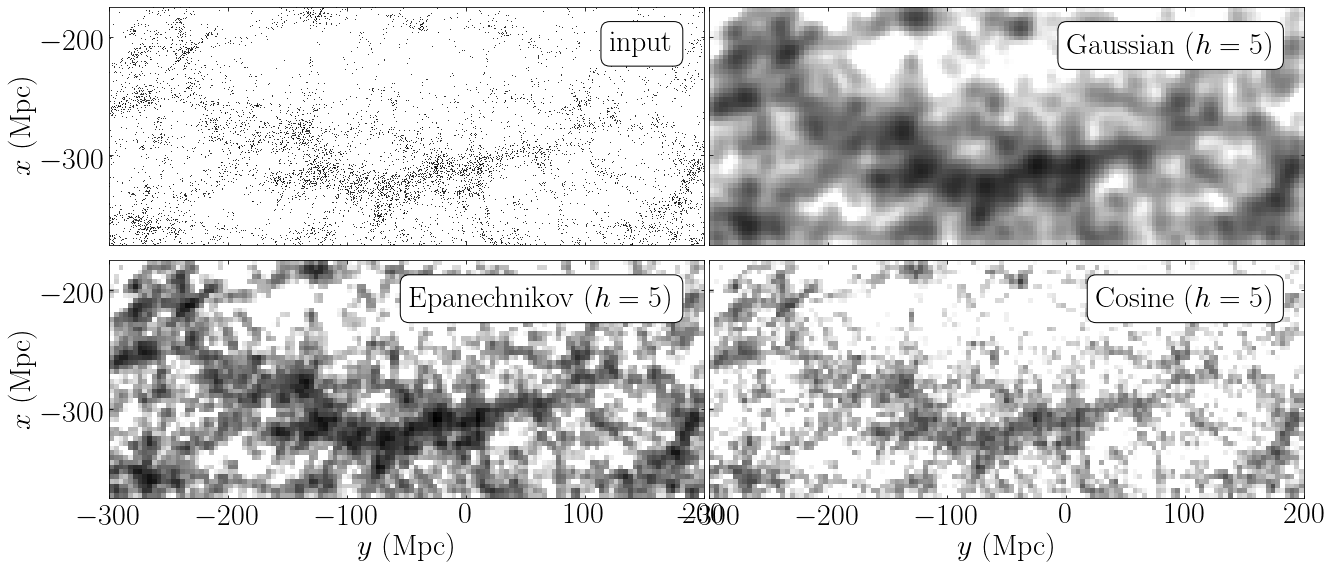

In [22]:
setup_text_plots(fontsize=30, usetex=True)
#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

if use_sklearn_KDE:
    kde1 = KernelDensity(5, kernel='gaussian')
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KernelDensity(5, kernel='epanechnikov')
    log_dens2 = kde2.fit(X).score_samples(Xgrid)
    dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KernelDensity(5, kernel='cosine')
    log_dens3 = kde3.fit(X).score_samples(Xgrid)
    dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax2.images[0].set_clim(0.01, 0.8)

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "Epanechnikov $(h=5)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "Cosine $(h=5)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax4.images[0].set_clim(0.01, 0.8)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Vary h

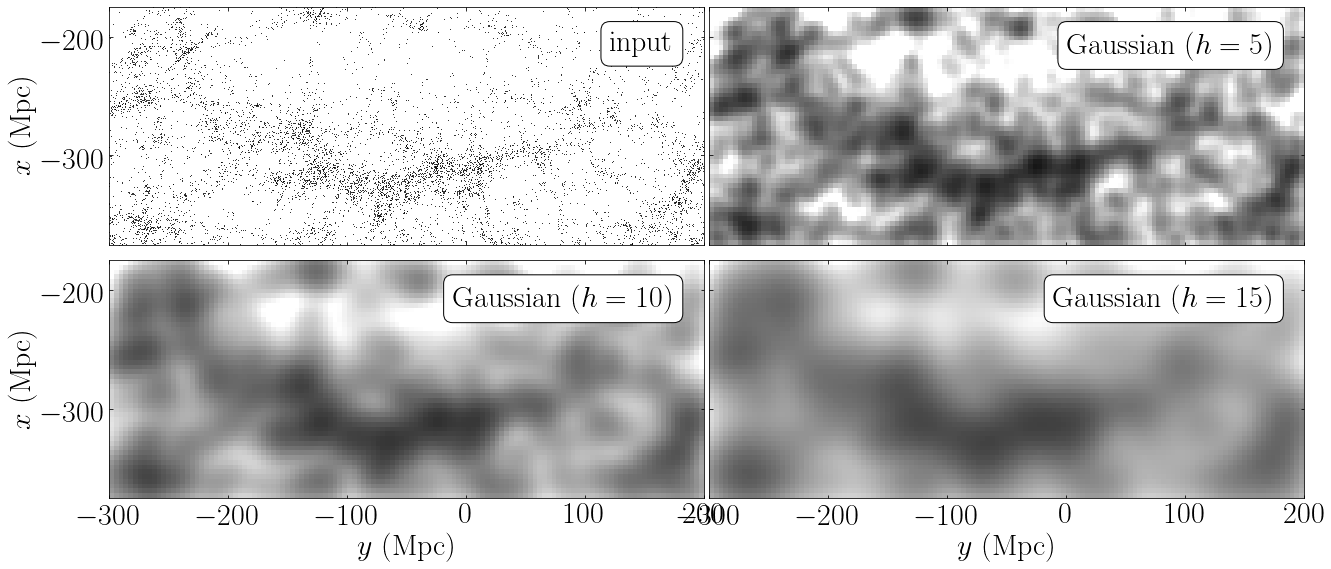

In [21]:
setup_text_plots(fontsize=30, usetex=True)
#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

if use_sklearn_KDE:
    kde1 = KernelDensity(5, kernel='gaussian')
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KernelDensity(10, kernel='gaussian')
    log_dens2 = kde2.fit(X).score_samples(Xgrid)
    dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KernelDensity(15, kernel='gaussian')
    log_dens3 = kde3.fit(X).score_samples(Xgrid)
    dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian $(h=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax2.images[0].set_clim(0.01, 0.8)

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "Gaussian $(h=10)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "Gaussian $(h=15)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax4.images[0].set_clim(0.01, 0.8)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Vary Color

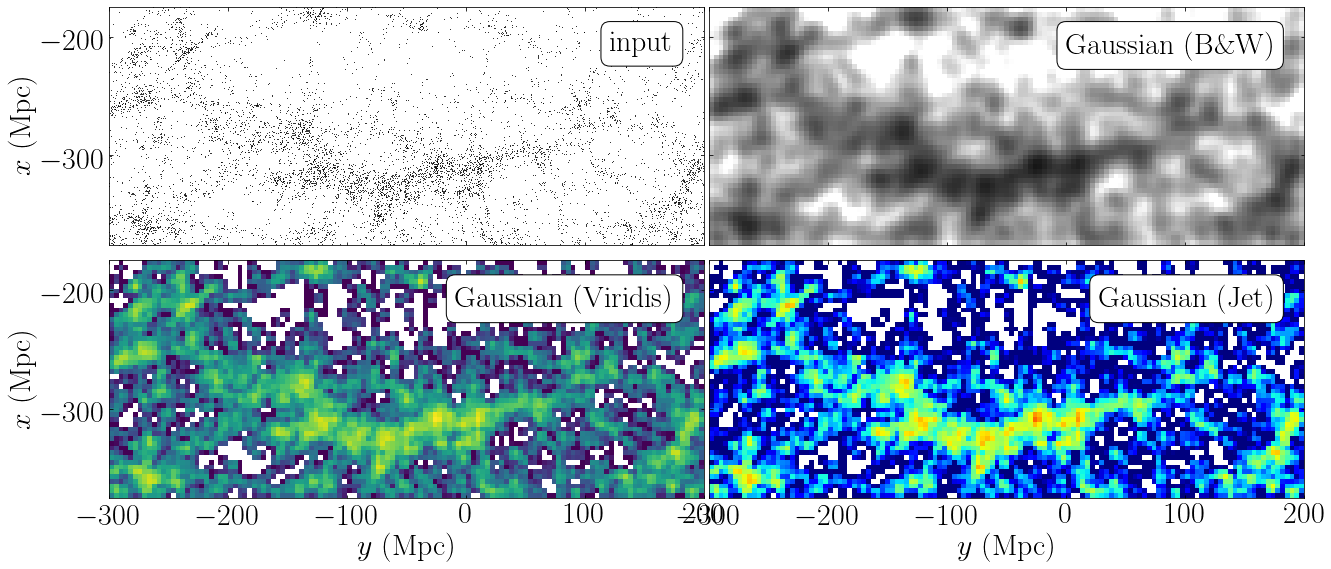

In [26]:
setup_text_plots(fontsize=30, usetex=True)
#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

if use_sklearn_KDE:
    kde1 = KernelDensity(5, kernel='gaussian')
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KernelDensity(5, kernel='epanechnikov')
    log_dens2 = kde2.fit(X).score_samples(Xgrid)
    dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KernelDensity(5, kernel='cosine')
    log_dens3 = kde3.fit(X).score_samples(Xgrid)
    dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: gaussian kernel
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "Gaussian (B\&W)", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax2.images[0].set_clim(0.01, 0.8)

# Third plot: top-hat kernel
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.viridis)
ax3.text(0.95, 0.9, "Gaussian (Viridis)", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax3.images[0].set_clim(0.01, 0.8)

# Fourth plot: exponential kernel
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.jet)
ax4.text(0.95, 0.9, "Gaussian (Jet)", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax4.images[0].set_clim(0.01, 0.8)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

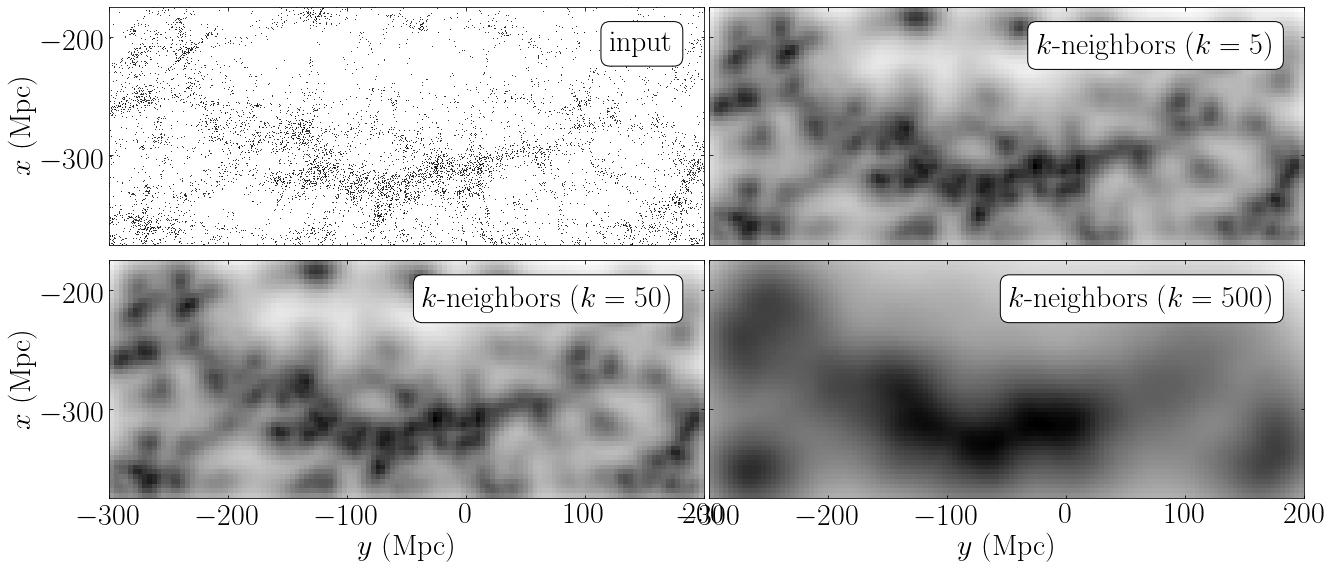

In [32]:
from astroML.density_estimation import KDE, KNeighborsDensity

setup_text_plots(fontsize=30, usetex=True)
#------------------------------------------------------------
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

#------------------------------------------------------------
# Evaluate for several models
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

kde = KNeighborsDensity('bayesian', 5)
dens_KDE = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn5 = KNeighborsDensity('bayesian', 50)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

knn40 = KNeighborsDensity('bayesian', 500)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# First plot: scatter the points
ax1 = plt.subplot(221, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Second plot: KDE
ax2 = plt.subplot(222, aspect='equal')
ax2.imshow(dens_KDE.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax2.text(0.95, 0.9, "$k$-neighbors $(k=5)$", ha='right', va='top',
         transform=ax2.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Third plot: KNN, k=5
ax3 = plt.subplot(223, aspect='equal')
ax3.imshow(dens_k5.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax3.text(0.95, 0.9, "$k$-neighbors $(k=50)$", ha='right', va='top',
         transform=ax3.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

# Fourth plot: KNN, k=40
ax4 = plt.subplot(224, aspect='equal')
ax4.imshow(dens_k40.T, origin='lower', norm=LogNorm(),
           extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
ax4.text(0.95, 0.9, "$k$-neighbors $(k=500)$", ha='right', va='top',
         transform=ax4.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax3, ax4]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax4]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax3]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()